# Problem Set 1 - K-Nearest Neighbor Classification and Regression
## CSCI 4622 - Spring 2023
***
**Name**: Alex Ojemann
***

This assignment is due on Canvas by **11:59PM on February 8th**.

Submit only this Jupyter notebook to Canvas with the name format `HW1_<yourname>.ipynb`. Do not compress it using tar, rar, zip, etc.
Your solutions to analysis questions should be done in Markdown directly below the associated question.

Remember that you are encouraged to discuss the problems with your classmates and instructors, 
but **you must write all code and solutions on your own, and list any people or sources consulted. Homework submissions will be automatically run through plagiarism checking tool.**


***
For today's assignment, we will be implementing our own K-Nearest Neighbors classifier and regressor algorithms.

*But Professor Quigley, hasn't someone else already written KNN before?*

Yes, you are not the first to implement KNN, or basically any algorithm we'll work with in this class. But
1. I'll know that you know what's really going on
2. You'll know you can do it, because
    1. someday you might have to implement some machine learning algorithm from scratch - maybe for a new platform (do you need to run python on your SmartToaster just to get it to learn how users like their toast?), maybe because you want to tweak the algorithm (there's always a better approach...),
    2. maybe because you're working on something important, and you need to control exactly what's on there (should you really be running anaconda on your secret spy plane?).

That said - we're not going to implement *everything*. We'll start by importing a few helper functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.neighbors
import data
import helpers
%matplotlib inline

*Wait a minute - didn't we just import Scikit-learn (sklearn)? The package with baked-in machine learning tools?*
 Yes - but it also has a ton of helper functions that we'll be using later.

You will be guided through the different questions. You'll be expected to complete the classes and the functions following the provided signatures.

Remember to avoid adding positional arguments and make sure the returned values have the correct format (this applies to all assignments).
The alternative is that your solution might be rejected by the auto-grader (we won't be debugging your code during grading).
We will provide some basic sanity checks. They're in no means exhaustive and passing them does not imply that your solution is 100% correct.

For example, you're required to complete the method `compute_something` of class A.
We provide examples of acceptable solutions.

In [3]:
# This cell can be removed from the submitted notebook
class A:
    def compute_something(self) -> np.ndarray:
        """
        Returns: numpy array of zeros, with shape (4,)
        """
        # BEGIN
        answer = np.zeros((4,))
        # END
        return answer


class A1:  # Acceptable solution:
    # - the added y is an optional argument and omitting it does not affect the solution
    # - the returned object has the expected structure.
    def compute_something(self, y=None):
        # BEGIN
        return np.zeros((4,))
        # END


class A2:  # Wrong format:
    # - your solution requires a new positional argument y!: critical
    # - the returned object does not have the expected format!: critical
    # - solution outside the delimiters # BEGIN # END: makes grading easier
    def compute_something(self, y):
        return [0, 0, 0, 0]


class A3:  # Acceptable solution:
    # You're free to add your own helper functions/methods,
    # but they should be defined in the jupyter notebook (no external files)
    def compute_something(self):
        # BEGIN
        return self.get_zeros(4)
        # END

    def get_zeros(self, i):
        return np.zeros((i,))


First, let's also load a dataset to play with and start working to build out our own classifier.

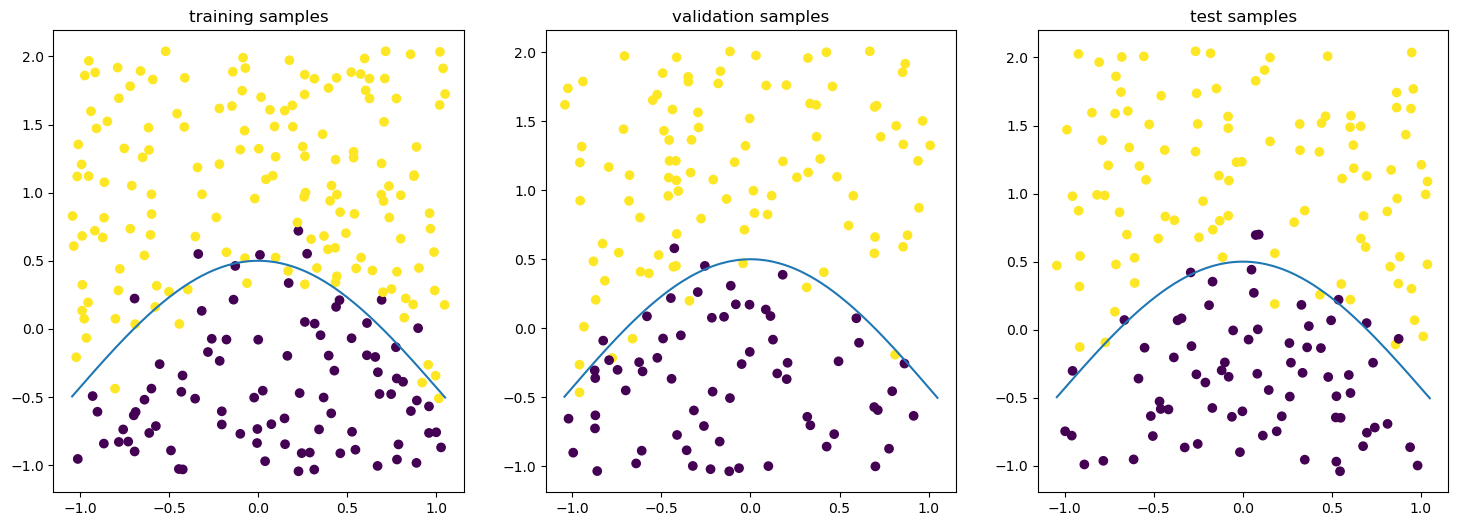

In [4]:
binary_data = data.BinaryData()
fig, axs = plt.subplots(1, 3)
fig.set_figheight(6), fig.set_figwidth(18)
for i, name in enumerate(["training", "validation", "test"]):
    axs[i].plot(*binary_data.boundary())
    axs[i].set_title("%s samples" % name)
axs[0].scatter(binary_data.X_train[:, 0], binary_data.X_train[:, 1], c=binary_data.y_train)
axs[1].scatter(binary_data.X_valid[:, 0], binary_data.X_valid[:, 1], c=binary_data.y_valid)
axs[2].scatter(binary_data.X_test[:, 0], binary_data.X_test[:, 1], c=binary_data.y_test)
plt.show()

We have data! The `binary_data` instance has the following attributes:
   - a training set (`X_train, y_train`): to train the model and on which the prediction is based
   - a validation set (`X_valid, y_valid`): to select the best __hyper-parameters__ of the model
   - a test set (`X_test, y_test`): to evaluate the performance of the model on unseen data

### Problem 1: Complete our KNN Classifier - 46 Points + 3 Bonus


The KNNClassifier class we're implementing will have similar design to the [KNeighbors classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) from *scikit-learn*:
- Initialize the classifier with corresponding parameters (number of neighbors k)
- A `fit` method that uses the training data
- A `predict` method that returns the predicted labels given data `X`

We've written out a lot of the structure for you for consistency across different parts of the assignment and so
you can focus on the "important" stuff that actually relates to machine learning itself.


In [5]:
class KNNClassifier:

    def __init__(self, k=5):
        """ Initialize our custom KNN classifier
        Args:
            k: the number of nearest neighbors to consider for classification
        """
        self._k = k
        self._ball_tree = None
        self._y = None
        self.label_to_index = None
        self.index_to_label = None
        self.population_most_common = None

    def fit(self, X, y):
        """ Fit the model using the provided data
        Args:
            X:  matrix of shape (num_training_samples, num_features)
            y: array of shape (num_training_samples,)
        Returns: Fit instance of KNNClassifier (self)
        """
        self._ball_tree = sklearn.neighbors.BallTree(X)  # See documentation of BallTree and how it's used
        self._y = y
        # Should be used to map the classes to {0,1,..C-1} if needed (C is the number of classes)
        # We can assume that the training data contains samples from all the possible classes
        classes = np.unique(y)
        self.label_to_index = dict(zip(classes, range(classes.shape[0])))
        self.index_to_label = dict(zip(range(classes.shape[0]), classes))
        
        label_values, label_counts = np.unique(y, return_counts=True)
        self.training_most_common = label_values[np.argmax(label_counts)]

        return self

    def sample_label(self, index):
        # helper method to get label of sample index in majority_vote
        assert index < self._y.shape[0]
        return self._y[index]

    def majority_vote(self, indices_nearest_k, distances_nearest_k=None):
        """ Given indices of the nearest k neighbors for each point,
            report the majority label of those points.
        Args:
            k_nearest_indices: 2-d array of the indices of training neighbors, of shape (M, k)
            k_nearest_distances: 2-d array of the corresponding distances of training neighbors, of shape (M, k)
        Returns: The majority label for each row of indices, shape (M,)
        """
        voted_labels = np.empty(indices_nearest_k.shape[0])  # to include
        # BEGIN 
        for i, index_row in enumerate(indices_nearest_k):
            labels = self._y[index_row]
            (values, counts) = np.unique(labels, return_counts=True)
            index = np.argmax(counts)
            voted_labels[i] = values[index]
        # END
        return voted_labels
        # Workspace 1.2
        # TODO: Determine majority for each row of indices_nearest_k
        # TODO: if there is a tie, set the label to the most common label in the training set
        

    def predict(self, X):
        """ Given new data points, classify them according to the training data
            provided in self.fit and number of neighbors self.k
            - You should use BallTree to get the distances and indices of
            the nearest k neighbors
        Args:
            X: feature vectors (num_samples, num_features)
        Returns:
            1-D array of predicted classes of shape (num_samples,)
        """
        # Workspace 1.1
        # inc distances_nearest_k, indices_nearest_k = None, None  # REPLACE
        # BEGIN 
        tree = self._ball_tree         
        distances_nearest_k, indices_nearest_k = tree.query(X, k=self._k)
        # END
        return self.majority_vote(indices_nearest_k, distances_nearest_k)

    def confusion_matrix(self, X, y):
        """ Generate the confusion matrix for the given data
        Args:
            X: data matrix, shape (num_samples, num_features)
            y: the corresponding correct classes of our set, shape (num_samples,)
        Returns: a CxC matrix, where C is the number of classes in our training data
        """

        # The rows of the confusion matrix correspond to the counts from the true labels, the columns to the predictions'
        # Workspace 1.3
        # TODO: Run classification for the test set X, compare to test answers y, and add counts to matrix
        c_matrix = np.zeros((len(self.label_to_index), len(self.label_to_index)))
        # BEGIN 
        # code here
        predictions = self.predict(X)

        for i in range(len(predictions)):
            true_label = y[i]
            pred_label = predictions[i]
            true_index = self.label_to_index[true_label]
            pred_index = self.label_to_index[pred_label]
            c_matrix[true_index][pred_index] += 1
    
        return c_matrix
        # END
        return c_matrix

    def accuracy(self, X, y):
        """ Return the accuracy of the classifier on the data (X, y)
        Args:
            X: matrix of shape (num_samples, num_features)
            y: array of shape (num_samples,)

        Returns: accuracy score [float in (0,1)]
        """
        # Workspace 1.4
        # TODO: Compute accuracy on X
        # inc score = 0
        # BEGIN 
        matrix = self.confusion_matrix(X,y)
        num_incorrect = matrix[0][0] + matrix[1][1]
        num_total = matrix[0][0] + matrix[0][1] + matrix[1][0] + matrix[1][1]
        score = num_incorrect / num_total
        # END
        return score

In [6]:
# Test cell, uncomment to run the tests
%run -i tests knnc

....
----------------------------------------------------------------------
Ran 4 tests in 0.008s

OK


<Figure size 640x480 with 0 Axes>

*But professor, this code isn't complete!*



**Q1.1** *[5 points]*  Complete the `predict` function to capture the predicted class of a new datapoint

 - HINT: Use the [BallTree documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree) to determine how to retrieve neighbors from the model

**Q1.2** *[10 points]*  Complete the `majority_vote` function to determine the majority class of a series of neighbors.
    If there is a tie, then you should remove the farthest element until the tie is broken.

**Q1.3** *[10 points]*  Complete the `confusion_matrix` function to reveal the results of classification

**Q1.4** *[5 points]*  Complete the `accuracy` function to get accuracy of the classifier based on a given test data

Below, we'll be using our KNNClassifier (sent in as "model") to show how we would predict any points in space given the input data.

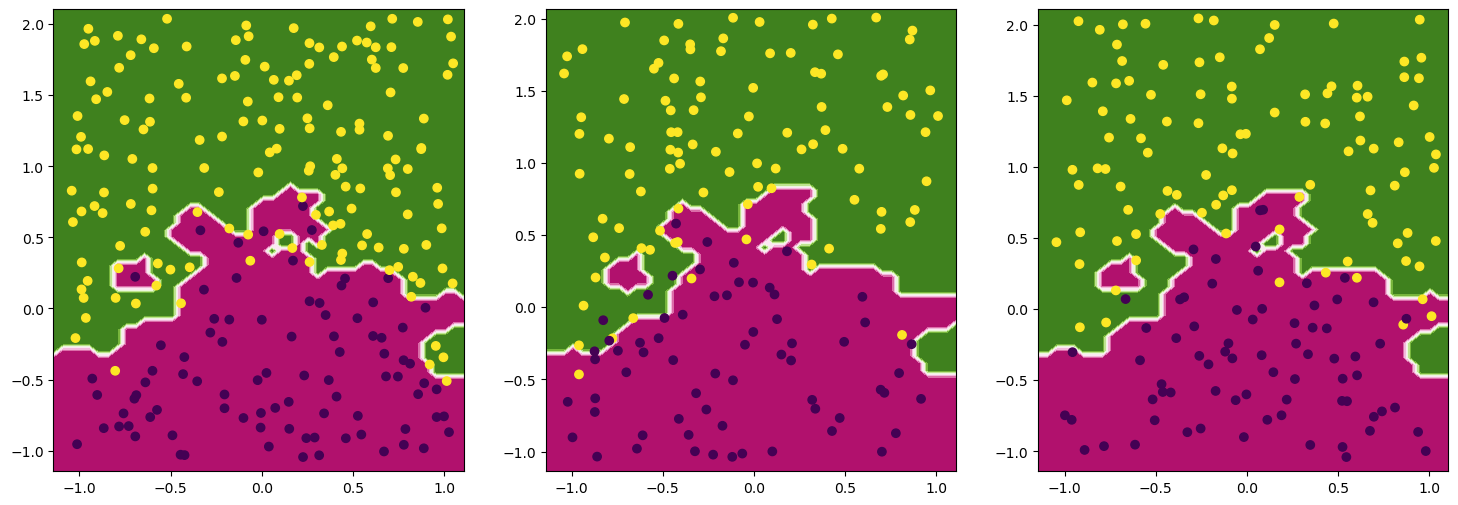

In [7]:
# This cell is to show the decision surface of the classifier
# You can change k to visualize KNN behavior
knn = KNNClassifier(2).fit(binary_data.X_train, binary_data.y_train)
fig, axs = plt.subplots(1, 3)
fig.set_figheight(6), fig.set_figwidth(18)
helpers.show_decision_surface(knn, binary_data.X_train, binary_data.y_train, axs[0])
helpers.show_decision_surface(knn, binary_data.X_valid, binary_data.y_valid, axs[1])
helpers.show_decision_surface(knn, binary_data.X_test, binary_data.y_test, axs[2])
plt.show()

**Q1.5** *[10 points]*  For each k in the range [1,32], fit a KNNClassifier on the training set and plot the accuracies on training and validation data versus k.

What's the value of k that yields the best accuracy on the training set? on the validation set? Which one should we choose?

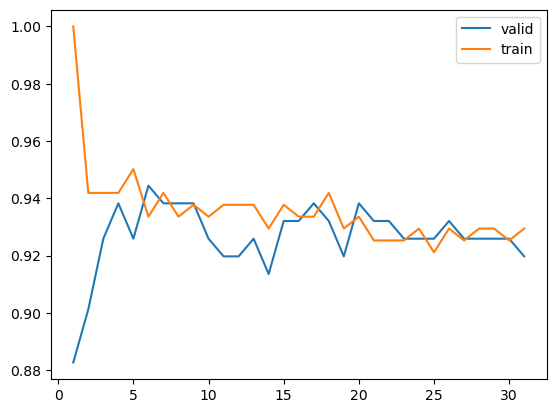

In [8]:
# Workspace 1.5.a
#TODO: Try different Ks
ks = list(range(1, 32))
accuracies_train = []
accuracies_valid = []
knn = None
for k in ks:
    # BEGIN 
    knn = KNNClassifier(k).fit(binary_data.X_train, binary_data.y_train)
    accuracies_train.append(knn.accuracy(binary_data.X_train,binary_data.y_train))
    accuracies_valid.append(knn.accuracy(binary_data.X_valid,binary_data.y_valid))
    # END
plt.plot(ks, accuracies_valid, label="valid")
plt.plot(ks, accuracies_train, label="train")
plt.legend()
plt.show()

### # Workspace 1.5.b
% Write up: best k for training and validation and which one should we choose

The best k for training was k=1 and the best k for validation is k=6. We should choose k=6 because k=1 overfits the training data while not being as successful on data where it can't overfit.

**Q1.6** *[6 points]*  Report the accuracy and the confusion matrix on the test set using the value of k chosen in 1.5

In [9]:
# Workspace 1.6
# TODO: compute and print the accuracy on the test set using k from 1.5
# inc best_k = None
# BEGIN 
# code here
knn = KNNClassifier(6).fit(binary_data.X_train, binary_data.y_train)
print(knn.confusion_matrix(binary_data.X_test, binary_data.y_test))
knn.accuracy(binary_data.X_test, binary_data.y_test)
# END

[[65.  7.]
 [ 4. 97.]]


0.9364161849710982

**Bonus (for the avid machine learner) (3 Points)**

1.7.a [1 point] A [__consistent classifier__](https://proceedings.neurips.cc/paper/1996/file/7bb060764a818184ebb1cc0d43d382aa-Paper.pdf)
on the training data is defined as a classifier that reaches 100% accuracy on the training set. For which values of k is KNNClassifier Consistent?

1.7.b [2 points] Edit your `KNNClassifier` so that it's consistent for all $k$ (we made sure that the change does not affect the sanity checks)

#### Write-up for the bonus
**Workspace 1.7.a**

% for which k in KNNClassifier consistent

% BEGIN

k=1

% END

***
OK - now we've demonstrated that our KNN classifier works, let's think about our problem space!

## Problem 2: Improving KNN on Digits dataset - 24 Points

It's a pretty common problem - just imagine working at the post office, and you're handed a hand-written check,
and you have to identify exactly what it says.
Did they pay 500 or 600 dollars? Is the letter going to 80309 (campus) or 30309 (Atlanta)?

**Q2.1** *[7 points]* Complete `prepare_data` by reporting the number of examples in different partitions of the digits dataset and the number of pixels in the images. You also have to reshape `X_train, X_valid, X_test` arrays as matrices for our KNNClassifier to use them.

Note: the question is simple and straight-forward, there is no trick here,



In [32]:
digit_data = data.DigitData()

In [58]:
def prepare_data(dataset: data.Dataset):
    """
    Report information about the dataset using the print() function and reshape X_? to 2-d arrays
    """
    # Workspace 2.1
    # BEGIN 
    #TODO: Create printouts for reporting the size of each set and the size of each datapoint
    # code here
    X_train = dataset.X_train
    X_test = dataset.X_test
    X_val = dataset.X_valid

    print(f'Training set size: {X_train.shape[0]}')
    print(f'Testing set size: {X_test.shape[0]}')
    print(f'Validation set size: {X_val.shape[0]}')

    # Reshape X_? to 2-d arrays
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1]*X_val.shape[2])

    # END
    return X_train, X_test, X_val
    # END

In [59]:
prepare_data(dataset=digit_data)

Training set size: 2625
Testing set size: 1250
Validation set size: 1125


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

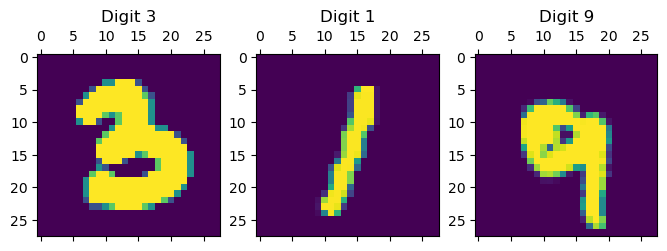

In [60]:
fig, ax = plt.subplots(1, 3, figsize=(8, 24))
helpers.view_digit(digit_index=1,dataset = digit_data, partition="test", ax=ax[0])
helpers.view_digit(digit_index=5,dataset = digit_data, partition="test", ax=ax[1])
helpers.view_digit(digit_index=5,dataset = digit_data, partition="valid", ax=ax[2])
plt.show()

Now we want to automatically perform the model selection from 1.5, 1.6


**Q2.2** *[10 points]* complete the `evaluate` to perform the same evaluation we did in 1.5:
 - For k in range (1, 20):
    - initialize the classifier for k  and train in on the training set
    - Compute the accuracy on the validation set and save it
 - Choose k with the best accuracy on the validation set
 - Report the accuracy and the confusion matrix on the test set (use `display_confusion` for a cleaner output)


In [64]:
def evaluate(ks_range,dataset: data.Dataset, KNNClass=KNNClassifier):
    """ Evaluate KNNClassifier of Dataset for k in ks_range by printing the accuracy and confusion matrix of the best k
    Args:
        ks_range: range of k values
        dataset: dataset
    """
    # Workspace 2.2
    best_valid_k = None
    confusion_matrix = None
    accuracy = 0
    ks = ks_range
    accuracies_valid = [] 
    (xTr, xTe, xV) = prepare_data(dataset=digit_data)
    print(len(xV))
    print(len(dataset.y_valid))
    for k in ks:
        print(k, end="\r")
        # BEGIN 
        KNNClass=KNNClassifier(k)
        KNNClass.fit(xTr, dataset.y_train)
        accuracy_valid = KNNClass.accuracy(xV, dataset.y_valid)
        if accuracy_valid > accuracy:
            accuracy = accuracy_valid
            confusion_matrix = KNNClass.confusion_matrix(xTe, dataset.y_test)
            best_valid_k = k
        # END
    print("best k:", best_valid_k)
    print("Accuracy on test set:", accuracy)
    helpers.display_confusion(confusion_matrix)
    return confusion_matrix


In the next cell, we run the evaluation on k in the range ${2...9}$.

Training set size: 2625
Testing set size: 1250
Validation set size: 1125
1125
1125
best k: 2
Accuracy on test set: 1.0


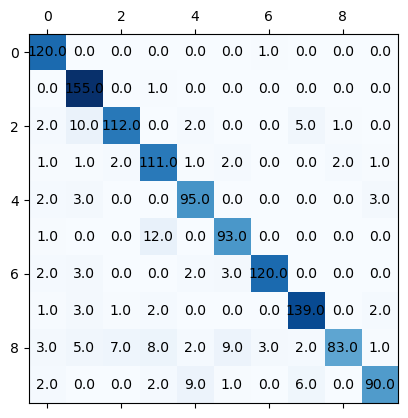

CPU times: user 27.3 s, sys: 296 ms, total: 27.6 s
Wall time: 27.2 s


array([[120.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.],
       [  0., 155.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  2.,  10., 112.,   0.,   2.,   0.,   0.,   5.,   1.,   0.],
       [  1.,   1.,   2., 111.,   1.,   2.,   0.,   0.,   2.,   1.],
       [  2.,   3.,   0.,   0.,  95.,   0.,   0.,   0.,   0.,   3.],
       [  1.,   0.,   0.,  12.,   0.,  93.,   0.,   0.,   0.,   0.],
       [  2.,   3.,   0.,   0.,   2.,   3., 120.,   0.,   0.,   0.],
       [  1.,   3.,   1.,   2.,   0.,   0.,   0., 139.,   0.,   2.],
       [  3.,   5.,   7.,   8.,   2.,   9.,   3.,   2.,  83.,   1.],
       [  2.,   0.,   0.,   2.,   9.,   1.,   0.,   6.,   0.,  90.]])

In [65]:
%%time
evaluate(range(2, 10), digit_data)
#Extra printouts are due to call of prepare_data()

**Q2.3** [7 points] Determine which classes are most often confused (from our confusion matrix above).
Display examples (at least 3) of **misclassified test instances** and explain why the KNNClassifier might have missed them.

<Figure size 640x480 with 0 Axes>

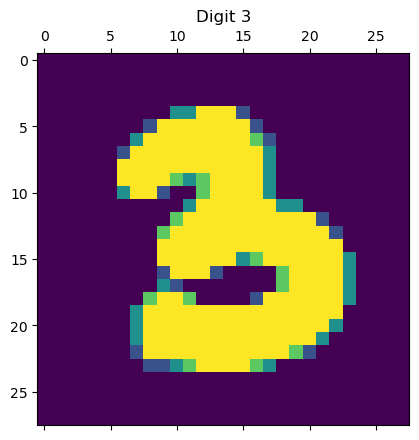

Training set size: 2625
Testing set size: 1250
Validation set size: 1125
1125
1125
best k: 2
Accuracy on test set: 1.0


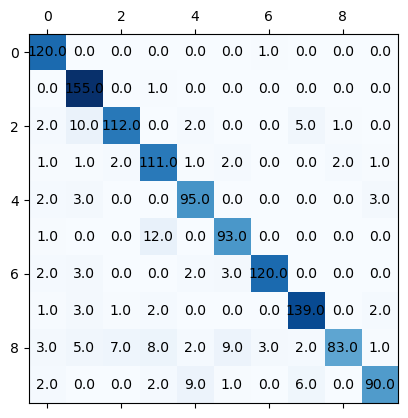

Training set size: 2625
Testing set size: 1250
Validation set size: 1125
Examples of misclassified instances:
Instance 17: True label: 4, Predicted label: 9.0


<Figure size 640x480 with 0 Axes>

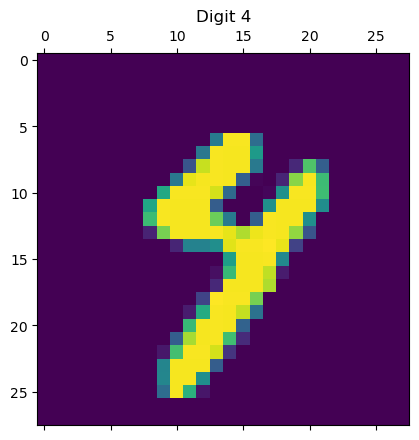

Instance 32: True label: 2, Predicted label: 7.0


<Figure size 640x480 with 0 Axes>

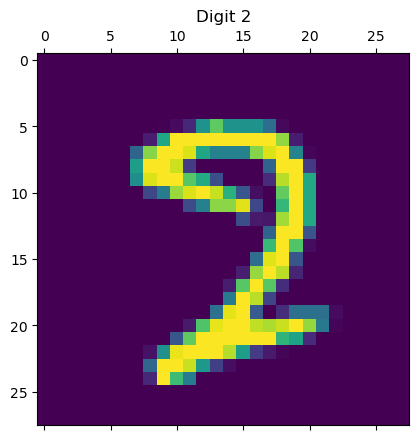

Instance 34: True label: 2, Predicted label: 1.0


<Figure size 640x480 with 0 Axes>

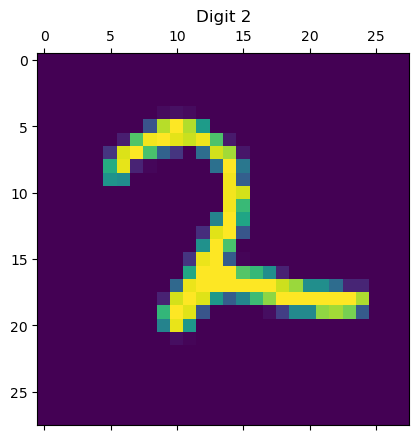

In [73]:
# Workspace 2.3.a
#TODO: Print out problem class images
helpers.view_digit(digit_index=1,dataset = digit_data, partition="test")
# BEGIN 
# code here
confusion_matrix = evaluate(range(2, 10), digit_data)
y = digit_data.y_train
(xTr, xTe, xV) = prepare_data(dataset=digit_data)
knn=KNNClassifier(k)
knn.fit(xTr, digit_data.y_train)
y_pred = knn.predict(xTr)

misclassified_indices = np.where(np.not_equal(y, y_pred))[0]
print("Examples of misclassified instances:")
for i in range(3):
    index = misclassified_indices[i]
    true_label = y[index]
    pred_label = y_pred[index]
    print(f"Instance {index}: True label: {true_label}, Predicted label: {pred_label}")
    helpers.view_digit(digit_index=index,dataset = digit_data, partition="train")
# END

**Workspace 2.3.b**

TODO: Write description of mis-classification

% BEGIN

8s appear to be misclassified the most because there are the most entries in row 8 of the confusion matrix that aren't in the same cloumn. It could be because they kind of look like 3s, 2s and 5s

% END

## Problem 3 - KNNRegressor [30 points]
***
Let's consider a different problem - Regression. Regression deals with continuous target values (labels).
For this problem we'll use the [California Housing Prices dataset](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset)

Features matrix shape: (13209, 8)


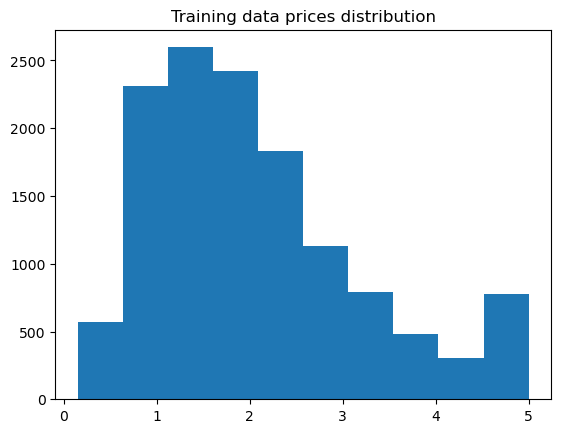

In [46]:
housing_data = data.HousingPrices()
print("Features matrix shape:", housing_data.X_train.shape)
plt.title("Training data prices distribution")
plt.hist(housing_data.y_train)
plt.show()

The KNNRegressor(k) predicts the target value by uniformly averaging the target values of the k-nearest neighbors from the training data.

**Q3.1** [10 points]  Complete `average_vote` function

**Q3.2** [10 points]  Complete the `mse` function. Do not use sklean built-in functions (only numpy functions).

In [47]:
class KNNRegressor(KNNClassifier):
    def average_vote(self, indices_nearest_k, distances_nearest_k=None):
        """ Given indices of the nearest k neighbors for each point, report the average y value of those points.
        Args:
            indices_nearest_k: np.array containing the indices of training neighbors, of shape (M, k)
            distances_nearest_k: np.array containing the corresponding distances of training neighbors,
            of shape (M, k), for the bonus
        Returns:The majority label for each row of indices, shape (M,)
        """

        # Workspace 3.1
        # TODO: Calculate the average y value for each set of neighbors and store in voted_labels
        voted_labels = np.empty(indices_nearest_k.shape[0])  # to include
        # BEGIN 
        # code here
        for i in range(indices_nearest_k.shape[0]):
            indices = indices_nearest_k[i, :]
            avg = np.mean(self._y[indices])
            voted_labels[i] = avg
        # END
        return voted_labels

    def predict(self, X):
        distances_nearest_k, indices_nearest_k = self._ball_tree.query(X, k=self._k)
        return self.average_vote(indices_nearest_k, distances_nearest_k)

    def mse(self, X, y):
        """
         Return the Mean Squared Error of the classifier
        Args:
            X: np.array of shape (m, number_features)
            y: np.array of shape (m,)
        Returns:MSE  (y, y_hat)
        """

        # Workspace 3.2
        # TODO: Compute mse across all samples
        score = 0
        # BEGIN 
        # code here
        y_hat = self.predict(X)  # assuming the class has a predict method
        m = y.shape[0]
        score = np.sum((y - y_hat)**2) / m
        # END
        return score

**Q3.3** [10 points] Similar to 1.5, for each k in the range [1,32], fit a KNNRegressor on the training set and plot the Mean Squared Errors on training and validation data versus k.

What's the value of k that yields the best mse on the training set? on the validation set? Which k should we choose?


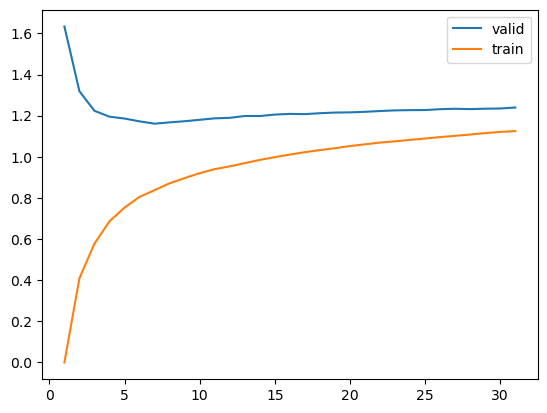

In [49]:
# Workspace 3.3.a
#TODO: Try different Ks
ks = list(range(1, 32))
accuracies_train = []
accuracies_valid = []
for k in ks:
    # BEGIN 
    # code here
    knn = KNNRegressor(k).fit(housing_data.X_train, housing_data.y_train)
    accuracies_train.append(knn.mse(housing_data.X_train,housing_data.y_train))
    accuracies_valid.append(knn.mse(housing_data.X_valid,housing_data.y_valid))
    # END
plt.plot(ks, accuracies_valid, label="valid")
plt.plot(ks, accuracies_train, label="train")
plt.legend()
plt.show()

#### Workspace 3.3 writeup

k=1 yields the best error for the training set. k=7 yields the best error on the validation set. We should use k=7 because the training model clearly overfits on k=1 and it's more telling when the error is best on the validation data that the model can't overfit on.

### Problem 4 : Improving KNN on MNIST using WeightedKNN (10 Bonus pts)
Complete the `WeightedKNNClassifier` class to perform the weighted KNN classification.
The Weighted KNN classifier assigns weights to the nearest-neighbor training examples proportional to
 the inverse-distance from the training example to the query point.

Classification is performed by summing the weights associated with each class and predicting the class with the highest weighted-majority vote.
 Mathematically, we might describe the weighted-vote for a class $c$ as

\begin{align}
\textrm{Weighted-Vote}(c)(x) = \sum_{i \in {\cal N}_K(x)} I(y_i \in c) \times \frac{1}{\|{\bf x}_i - {\bf x}\|}
\end{align}

where ${\cal N}_K(x)$ is the set of the nearest $k$ neighbors to $x$.

**Q4.1** *[5 points]* Complete `weighted_vote`: it's certainly possible that a query point could be distance $0$ away from some training example.

 If this happens your implementation should handle it and return the appropriate class label.


In [ ]:
class WeightedKNNClassifier(KNNClassifier):

    def weighted_vote(self, indices_nearest_k, distances_nearest_k):
        """ Given indices of nearest neighbors in training set, return the majority label.
        Break ties by considering 1 fewer neighbor until a clear winner is found.
        Args:
            indices_nearest_k: The indices of the K nearest neighbors in self.X_train
            distances_nearest_k: Corresponding distances from query point to K nearest neighbors.
        Returns: predicted labels
        """

        # Workspace 4.1
        
        labels = []  #You can replace
        # BEGIN 
        # code here
        # END

        return labels

    def predict(self, X):
        """ Given an np.array of query points, return y_hat, an np.array of predictions
        Args:
            X: an (m x p) dimension np.array of points to predict labels for
        Returns: predicted labels
        """

        distances_nearest_k, indices_nearest_k = self._ball_tree.query(X, k=self._k)
        labels = self.weighted_vote(indices_nearest_k, distances_nearest_k)
        return labels

In [ ]:
# Test cell, uncomment to run the tests
%run -i tests weightedknnc

In [ ]:
# Example on how to use the show_decision_surface
knn = WeightedKNNClassifier(3).fit(binary_data.X_train, binary_data.y_train)
helpers.show_decision_surface(knn, binary_data.X, binary_data.y)

**Q4.2** *[3 points]*Evaluate `WeightedKNNClassifier` on the binary data (use `evaluate` function)

In [ ]:
# Workspace 4.2
# BEGIN 
# code here
# END

### # Workspace 4.3.b
% Write up: Which classifier does better on the binary data

**Q4.3** *[2 points]* Compare `WeightedKNNClassifier` to `KNNClassifier` on the digits' data using `Numbers` class.

In [ ]:
#Workspace 4.3.a
# BEGIN 
# code here
# END


### # Workspace 4.3.b
% Write up: Which classifier does better on the binary data

% BEGIN

% YOUR ANSWER HERE

% END